# Introduction to Time Series Forecasting
We explore a univariate time series forecasting problem through 2 real world datasets sourced from a gaming company.
These datasets contain information about the total number of *ad views* and the amount of *game currency* spent while playing the game. Both of these datasets have been recorded at different time scales.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [91]:
ads = pd.read_csv('ads.csv',parse_dates=['Time'])
currency = pd.read_csv('currency.csv',parse_dates=['Time'])
print(ads.shape)
ads.head()

(216, 2)


,Time,Ads
0,2017-09-13 00:00:00,80115
1,2017-09-13 01:00:00,79885
2,2017-09-13 02:00:00,89325
3,2017-09-13 03:00:00,101930
4,2017-09-13 04:00:00,121630


In [92]:
print(currency.shape)
currency.head()

(300, 2)


,Time,GEMS_GEMS_SPENT
0,2017-05-01,1199436
1,2017-05-02,1045515
2,2017-05-03,586111
3,2017-05-04,856601
4,2017-05-05,793775


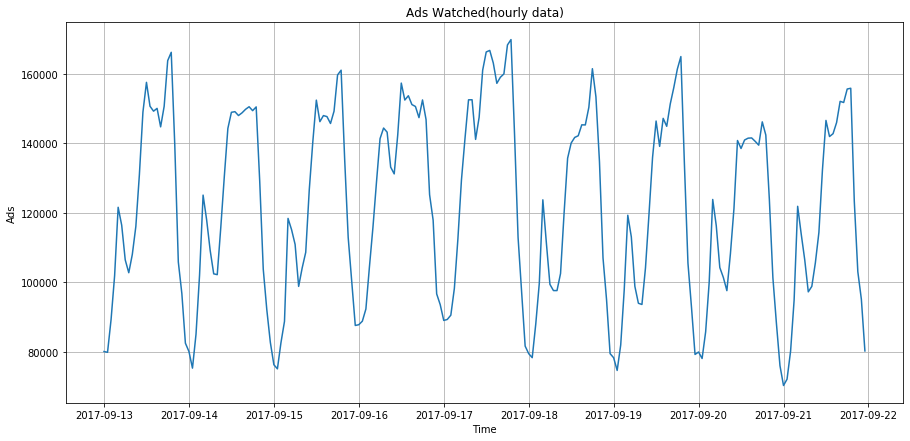

In [93]:
import seaborn as sns
fig, ax= plt.subplots(figsize=(15,7))
sns.lineplot(x=ads['Time'],y= ads['Ads'],data = ads)#,style=True,markers=True)
plt.grid(True)
plt.title("Ads Watched(hourly data)")
plt.show()

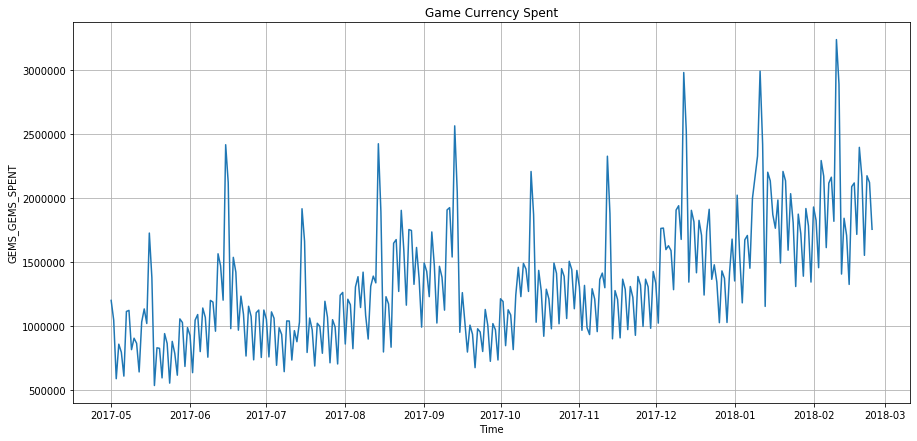

In [94]:
import seaborn as sns
fig, ax= plt.subplots(figsize=(15,7))
sns.lineplot(x=currency['Time'],y= currency['GEMS_GEMS_SPENT'],data = currency)
plt.grid(True)
plt.title("Game Currency Spent")
plt.show()

In [95]:
ads=ads.set_index('Time')
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


# Plot Rolling Window Statistics to check Stationarity

We write a functon which plots the rolling mean and standard deviation using the given window size.
Dickey Fuller Test is also performed to check for stationarity

In [96]:
def plot_time_series(ts,window):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from statsmodels.tsa.stattools import adfuller #Dickey Fuller Test for stationarity
    ts=ts.dropna()
    rolling_mean = ts['Ads'].rolling(window).mean()
    rolling_std  = ts['Ads'].rolling(window).std()
    fig, ax= plt.subplots(figsize=(15,7))
    ax.plot(ts['Ads'],color='blue',alpha=0.5)
    ax.plot(rolling_mean,color='green')
    ax.plot(rolling_std,color='red')
    plt.legend(['Original','Rolling Mean','Rolling Std'],loc='upper right')
    plt.title("Time series with Rolling Statistics of Window= {} ".format(window))
    plt.show()
    #Perform Dickey-Fuller test:
    print('\n----------------Results of Dickey-Fuller Test:----------------\n')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

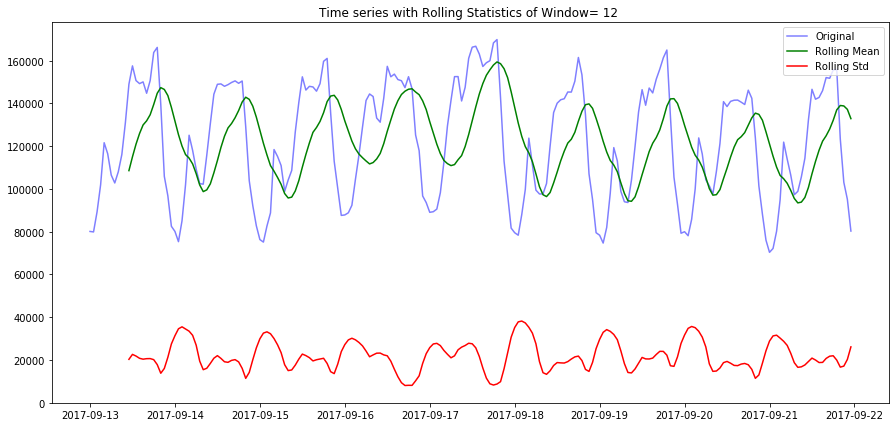


----------------Results of Dickey-Fuller Test:----------------

Test Statistic                -7.089634e+00
p-value                        4.444804e-10
#Lags Used                     9.000000e+00
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


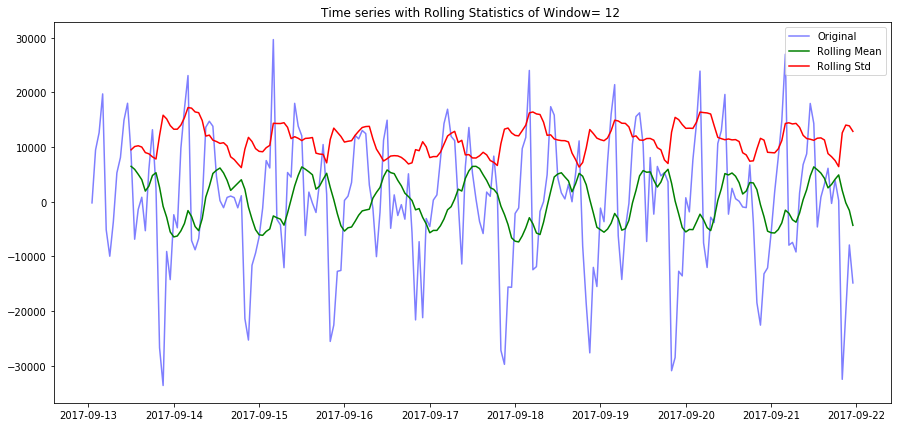


----------------Results of Dickey-Fuller Test:----------------

Test Statistic                -6.614309e+00
p-value                        6.262978e-09
#Lags Used                     1.500000e+01
Number of Observations Used    1.990000e+02
Critical Value (1%)           -3.463645e+00
Critical Value (5%)           -2.876176e+00
Critical Value (10%)          -2.574572e+00
dtype: float64


In [97]:
plot_time_series(ads,window=12)
# Time Series with 1st differencing
plot_time_series(ads.diff(),window=12)
# Time series 2nd differencing
#plot_time_series(ads.diff().diff(),window=12)

### Test statistic should be smaller than the critical-values if the series is stationary

# Decompose TimeSeries into Trend, Seasonality and Residuals

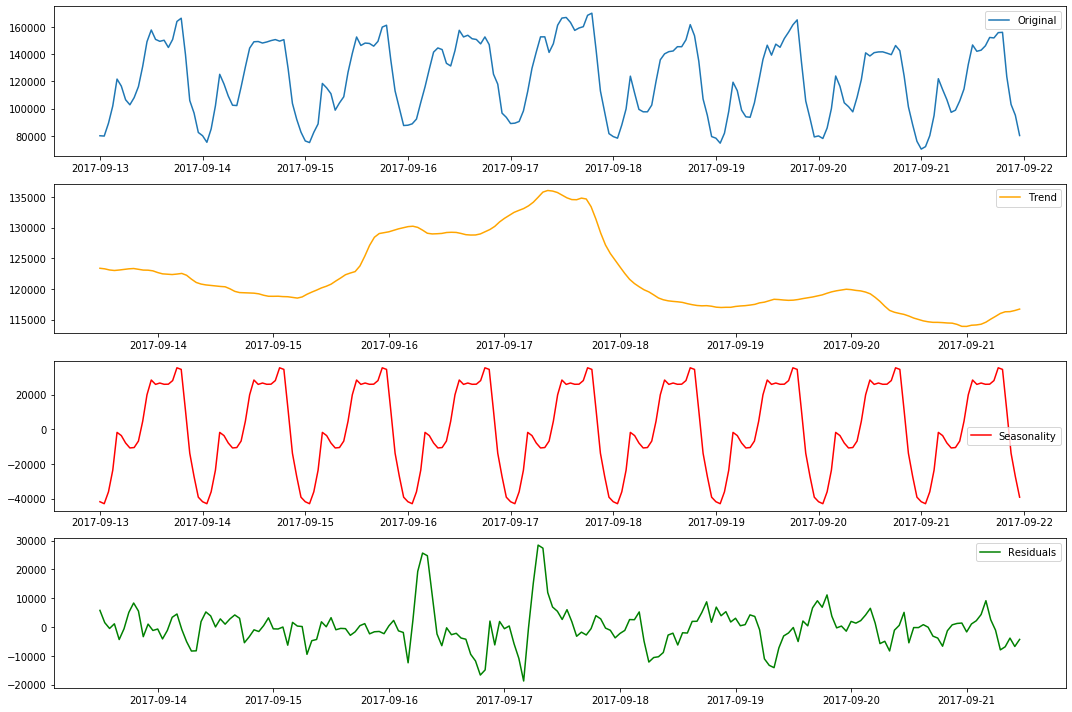

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ads)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, ax= plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(ads, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend',color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color='red')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals',color='green')
plt.legend(loc='best')
plt.tight_layout()

# FORECASTING USING TRADITIONAL TIME SERIES MODELS 

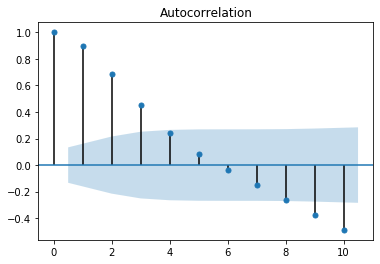

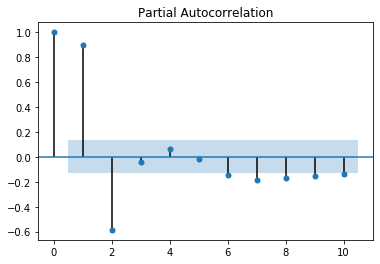

In [99]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ads, lags=10)
plot_pacf(ads, lags=10)
plt.show()

In [100]:
arma_mod20 = ARIMA(ads_train, order=(2, 0, 2)).fit()

/home/siddharth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [101]:
ads_train = ads[:158]
ads_test = ads[158:]

## AR Model
We fit an AR model with p=2,d=0,q=0 

In [102]:
model = ARIMA(ads_train.values, order=(2,0,0))  
results_ARIMA = model.fit(disp=-1)  
y_pred_ar =  results_ARIMA.fittedvalues
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE% = ',mean_absolute_percentage_error(ads_test,y_pred_ar))

MAPE% =  28.01177047601517


# ARMA Model
Next up we fit an ARMA model with p=2,d=0,q=2

In [103]:
model = ARIMA(ads_train.values, order=(2,0,2))  
results_ARIMA = model.fit(disp=-1)  
y_pred_ar =  results_ARIMA.fittedvalues
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE% = ',mean_absolute_percentage_error(ads_test,y_pred_ar))

MAPE% =  27.99410245351069


# FORECASTING TIME SERIES USING MACHINE LEARNING

# Feature Engineering
We create 3 types of features from the dataset
- **Lag Features**
- **Date-Time Features**
- **Rolling Window Summary Statistics**

In [104]:
ads.diff().head()

,Ads
Time,
2017-09-13 00:00:00,NaN
2017-09-13 01:00:00,-230.0
2017-09-13 02:00:00,9440.0
2017-09-13 03:00:00,12605.0
2017-09-13 04:00:00,19700.0


In [105]:
from sklearn.model_selection import TimeSeriesSplit

In [106]:
ads_ts = ads
ads_ts['hour_of_day'] = ads_ts.index.hour
ads_ts.head()

,Ads,hour_of_day
Time,,
2017-09-13 00:00:00,80115,0
2017-09-13 01:00:00,79885,1
2017-09-13 02:00:00,89325,2
2017-09-13 03:00:00,101930,3
2017-09-13 04:00:00,121630,4


In [107]:
def create_lagged_features(ads_ts,lag):
    for i in range(1,lag+1):
        feature_name = "Ads_lag{}".format(i)
        ads_ts[feature_name]=ads_ts['Ads'].shift(i);
    ads_ts.dropna()

In [108]:
create_lagged_features(ads_ts,lag=6)
ads_ts = ads_ts.dropna()
ads_ts.head()

,Ads,hour_of_day,Ads_lag1,Ads_lag2,Ads_lag3,Ads_lag4,Ads_lag5,Ads_lag6
Time,,,,,,,,
2017-09-13 06:00:00,106495,6,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0
2017-09-13 07:00:00,102795,7,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0
2017-09-13 08:00:00,108055,8,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0
2017-09-13 09:00:00,116125,9,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0
2017-09-13 10:00:00,131030,10,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0


## Create Window Features

In [109]:
def create_rolling_window_features(ads_ts,window=1):
    ads_ts['rolling_mean_{}'.format(window)]= ads_ts['Ads'].shift(window-1).rolling(window).mean()
    ads_ts['rolling_std_{}'.format(window)]= ads_ts['Ads'].shift(window-1).rolling(window).std()
    ads_ts['rolling_max_{}'.format(window)]= ads_ts['Ads'].shift(window-1).rolling(window).max()
    ads_ts['rolling_min_{}'.format(window)]= ads_ts['Ads'].shift(window-1).rolling(window).min()

In [110]:
create_rolling_window_features(ads_ts,window=3)
ads_ts = ads_ts.dropna()
ads_ts.head()

/home/siddharth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/siddharth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/siddharth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,Ads,hour_of_day,Ads_lag1,Ads_lag2,Ads_lag3,Ads_lag4,Ads_lag5,Ads_lag6,rolling_mean_3,rolling_std_3,rolling_max_3,rolling_min_3
Time,,,,,,,,,,,,
2017-09-13 10:00:00,131030,10,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,105781.666667,2701.579785,108055.0,102795.0
2017-09-13 11:00:00,149020,11,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,108991.666667,6714.181509,116125.0,102795.0
2017-09-13 12:00:00,157590,12,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,118403.333333,11655.717839,131030.0,108055.0
2017-09-13 13:00:00,150715,13,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,132058.333333,16471.592465,149020.0,116125.0
2017-09-13 14:00:00,149295,14,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,145880.000000,13555.556056,157590.0,131030.0


In [111]:
ads_ts.shape

(206, 12)

In [112]:
ads_ts.tail(48)

,Ads,hour_of_day,Ads_lag1,Ads_lag2,Ads_lag3,Ads_lag4,Ads_lag5,Ads_lag6,rolling_mean_3,rolling_std_3,rolling_max_3,rolling_min_3
Time,,,,,,,,,,,,
2017-09-20 00:00:00,79980,0,79270.0,92855.0,105585.0,134090.0,165010.0,161385.0,110843.333333,21114.422993,134090.0,92855.0
2017-09-20 01:00:00,78110,1,79980.0,79270.0,92855.0,105585.0,134090.0,165010.0,92570.000000,13159.814778,105585.0,79270.0
2017-09-20 02:00:00,85785,2,78110.0,79980.0,79270.0,92855.0,105585.0,134090.0,84035.000000,7646.589109,92855.0,79270.0
2017-09-20 03:00:00,100010,3,85785.0,78110.0,79980.0,79270.0,92855.0,105585.0,79120.000000,943.980932,79980.0,78110.0
2017-09-20 04:00:00,123880,4,100010.0,85785.0,78110.0,79980.0,79270.0,92855.0,81291.666667,4002.094243,85785.0,78110.0
2017-09-20 05:00:00,116335,5,123880.0,100010.0,85785.0,78110.0,79980.0,79270.0,87968.333333,11112.052391,100010.0,78110.0
2017-09-20 06:00:00,104290,6,116335.0,123880.0,100010.0,85785.0,78110.0,79980.0,103225.000000,19249.920130,123880.0,85785.0
2017-09-20 07:00:00,101440,7,104290.0,116335.0,123880.0,100010.0,85785.0,78110.0,113408.333333,12201.158073,123880.0,100010.0
2017-09-20 08:00:00,97635,8,101440.0,104290.0,116335.0,123880.0,100010.0,85785.0,114835.000000,9880.765406,123880.0,104290.0


# Prepare Train-Test data

In [113]:
from sklearn.linear_model import LinearRegression
y = ads_ts['Ads']
X = ads_ts.drop(['Ads'],axis=1)
X_train = X.iloc[:158,]
y_train = y[:158]
X_test = X.iloc[158:,]
y_test = y[158:]

In [114]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
    from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    tscv = TimeSeriesSplit(n_splits=5)
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

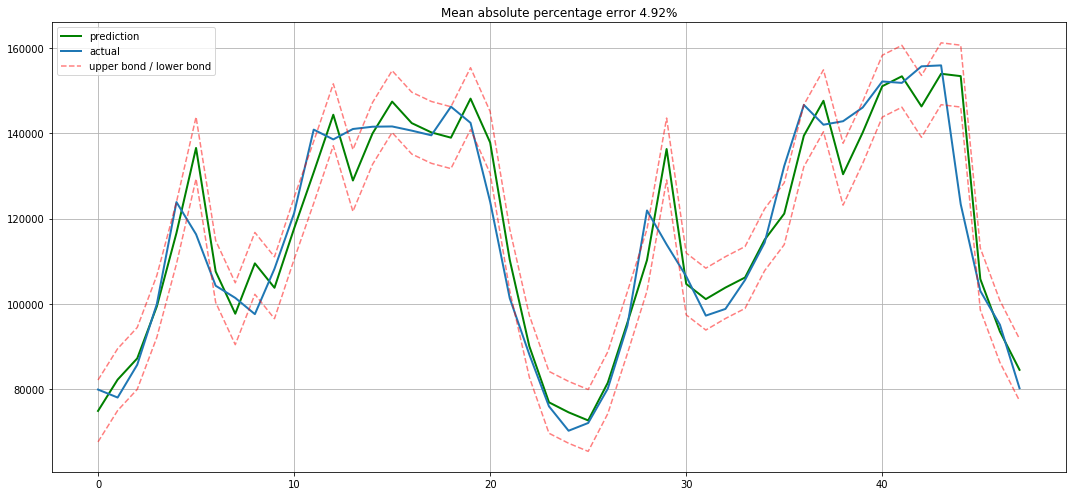

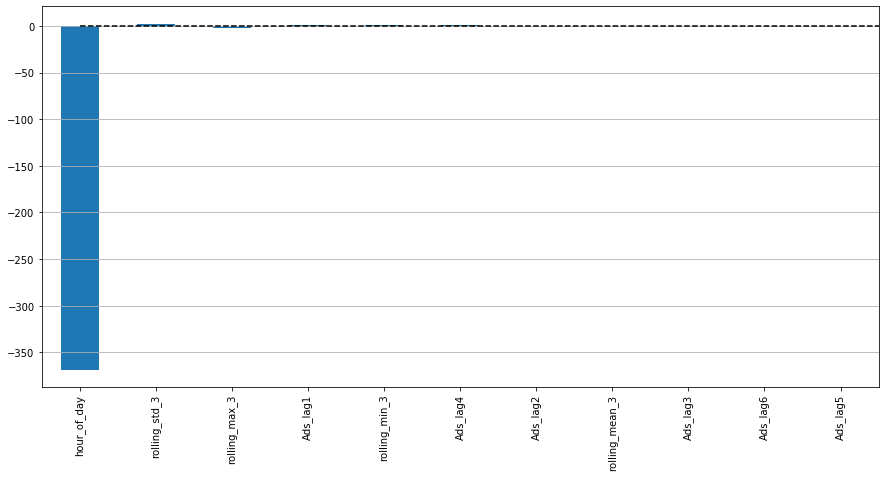

In [116]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

# Linear Regression on Scaled Dataset

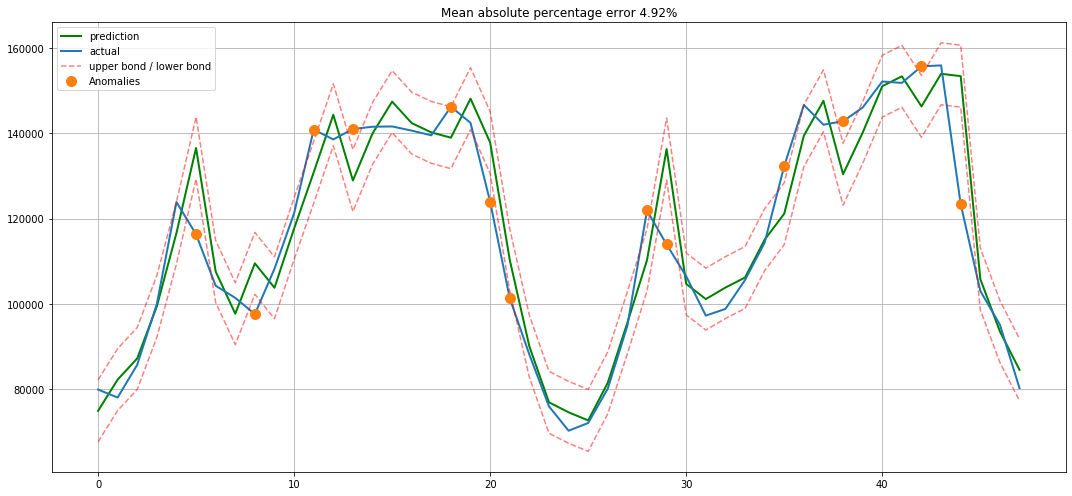

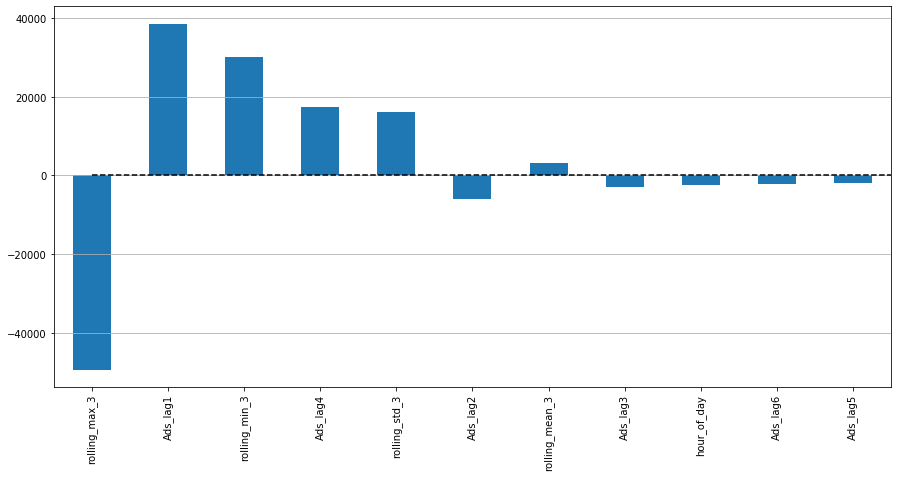

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [118]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
import numpy as np
X = X.astype(np.float32)
offset = 158
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

/home/siddharth/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
 78%|███████▊  | 31/40 [00:01<00:00, 19.93it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 95%|█████████▌| 38/40 [00:01<00:00, 19.80it/s]

Learning rate set to 0.028104
0:	learn: 27046.9848748	total: 75.2ms	remaining: 1m 15s
1:	learn: 26548.7450140	total: 80.8ms	remaining: 40.3s
2:	learn: 26129.9048873	total: 86.2ms	remaining: 28.7s
3:	learn: 25696.9182296	total: 91.6ms	remaining: 22.8s
4:	learn: 25259.6633881	total: 96.8ms	remaining: 19.3s
5:	learn: 24801.6121200	total: 101ms	remaining: 16.8s
6:	learn: 24331.5760022	total: 106ms	remaining: 15s
7:	learn: 23872.2499965	total: 110ms	remaining: 13.7s
8:	learn: 23484.5871005	total: 115ms	remaining: 12.7s
9:	learn: 23045.1735004	total: 119ms	remaining: 11.8s
10:	learn: 22638.5803017	total: 124ms	remaining: 11.1s
11:	learn: 22231.6433204	total: 128ms	remaining: 10.6s
12:	learn: 21849.5052271	total: 133ms	remaining: 10.1s
13:	learn: 21464.5149381	total: 138ms	remaining: 9.7s
14:	learn: 21055.0677009	total: 142ms	remaining: 9.3s
15:	learn: 20702.0773337	total: 144ms	remaining: 8.88s
16:	learn: 20324.9924011	total: 147ms	remaining: 8.5s
17:	learn: 19985.6738470	total: 150ms	remain

226:	learn: 3457.4291513	total: 354ms	remaining: 1.2s
227:	learn: 3445.5921428	total: 355ms	remaining: 1.2s
228:	learn: 3433.4912035	total: 356ms	remaining: 1.2s
229:	learn: 3419.3936731	total: 357ms	remaining: 1.2s
230:	learn: 3406.6952136	total: 358ms	remaining: 1.19s
231:	learn: 3393.5749303	total: 359ms	remaining: 1.19s
232:	learn: 3382.0884408	total: 360ms	remaining: 1.19s
233:	learn: 3366.7793837	total: 361ms	remaining: 1.18s
234:	learn: 3355.0854756	total: 362ms	remaining: 1.18s
235:	learn: 3346.6727131	total: 363ms	remaining: 1.18s
236:	learn: 3334.4034924	total: 364ms	remaining: 1.17s
237:	learn: 3322.8442219	total: 365ms	remaining: 1.17s
238:	learn: 3313.6266652	total: 366ms	remaining: 1.17s
239:	learn: 3299.1418136	total: 367ms	remaining: 1.16s
240:	learn: 3287.8644920	total: 368ms	remaining: 1.16s
241:	learn: 3276.6561672	total: 370ms	remaining: 1.16s
242:	learn: 3265.7080216	total: 371ms	remaining: 1.15s
243:	learn: 3256.7502692	total: 372ms	remaining: 1.15s
244:	learn: 32

407:	learn: 2078.2011613	total: 537ms	remaining: 779ms
408:	learn: 2072.3792918	total: 538ms	remaining: 777ms
409:	learn: 2069.0711927	total: 543ms	remaining: 781ms
410:	learn: 2064.8655817	total: 544ms	remaining: 779ms
411:	learn: 2061.0335857	total: 545ms	remaining: 778ms
412:	learn: 2057.0696921	total: 546ms	remaining: 776ms
413:	learn: 2051.9728181	total: 547ms	remaining: 775ms
414:	learn: 2045.3457140	total: 548ms	remaining: 773ms
415:	learn: 2041.0566140	total: 549ms	remaining: 771ms
416:	learn: 2037.9946668	total: 551ms	remaining: 770ms
417:	learn: 2033.5902693	total: 552ms	remaining: 768ms
418:	learn: 2028.5729944	total: 553ms	remaining: 767ms
419:	learn: 2027.3613863	total: 554ms	remaining: 766ms
420:	learn: 2023.6643294	total: 556ms	remaining: 764ms
421:	learn: 2015.6541834	total: 557ms	remaining: 763ms
422:	learn: 2008.3202531	total: 558ms	remaining: 761ms
423:	learn: 2003.2110493	total: 559ms	remaining: 759ms
424:	learn: 1999.2717419	total: 560ms	remaining: 757ms
425:	learn

612:	learn: 1325.1732573	total: 721ms	remaining: 455ms
613:	learn: 1322.1143001	total: 722ms	remaining: 454ms
614:	learn: 1318.9530558	total: 723ms	remaining: 453ms
615:	learn: 1315.1183106	total: 724ms	remaining: 452ms
616:	learn: 1311.7595711	total: 726ms	remaining: 451ms
617:	learn: 1308.2660110	total: 727ms	remaining: 450ms
618:	learn: 1307.3284399	total: 728ms	remaining: 448ms
619:	learn: 1305.6543662	total: 729ms	remaining: 447ms
620:	learn: 1302.5878963	total: 731ms	remaining: 446ms
621:	learn: 1299.2621710	total: 732ms	remaining: 445ms
622:	learn: 1296.3956993	total: 733ms	remaining: 443ms
623:	learn: 1294.8547993	total: 734ms	remaining: 442ms
624:	learn: 1291.8797520	total: 735ms	remaining: 441ms
625:	learn: 1289.2459127	total: 737ms	remaining: 440ms
626:	learn: 1286.7383201	total: 739ms	remaining: 440ms
627:	learn: 1284.6137268	total: 740ms	remaining: 438ms
628:	learn: 1282.2641220	total: 742ms	remaining: 438ms
629:	learn: 1279.1070015	total: 743ms	remaining: 437ms
630:	learn

815:	learn: 896.6308915	total: 903ms	remaining: 204ms
816:	learn: 894.6684905	total: 904ms	remaining: 203ms
817:	learn: 893.8539667	total: 906ms	remaining: 201ms
818:	learn: 893.4250366	total: 907ms	remaining: 200ms
819:	learn: 892.7332772	total: 908ms	remaining: 199ms
820:	learn: 890.8735356	total: 909ms	remaining: 198ms
821:	learn: 889.7079904	total: 910ms	remaining: 197ms
822:	learn: 889.4191679	total: 911ms	remaining: 196ms
823:	learn: 888.4294160	total: 912ms	remaining: 195ms
824:	learn: 886.5255564	total: 913ms	remaining: 194ms
825:	learn: 885.0944757	total: 914ms	remaining: 193ms
826:	learn: 882.2767409	total: 915ms	remaining: 191ms
827:	learn: 879.9096570	total: 916ms	remaining: 190ms
828:	learn: 879.1591014	total: 917ms	remaining: 189ms
829:	learn: 877.1472985	total: 919ms	remaining: 188ms
830:	learn: 876.1545839	total: 920ms	remaining: 187ms
831:	learn: 874.3480216	total: 921ms	remaining: 186ms
832:	learn: 872.3622053	total: 923ms	remaining: 185ms
833:	learn: 869.7813175	tota

100%|██████████| 40/40 [00:03<00:00, 10.59it/s]


In [119]:
print(models)

                               R-Squared      RMSE  Time Taken
Model                                                         
GradientBoostingRegressor           0.96   5302.19        0.06
ExtraTreesRegressor                 0.95   5877.15        0.12
LGBMRegressor                       0.94   6210.85        0.13
CatBoostRegressor                   0.94   6237.79        1.79
RandomForestRegressor               0.94   6244.91        0.16
XGBRegressor                        0.93   6583.22        0.30
HistGradientBoostingRegressor       0.93   6681.74        0.14
BaggingRegressor                    0.93   6796.98        0.02
AdaBoostRegressor                   0.92   7190.38        0.09
DecisionTreeRegressor               0.90   7913.63        0.01
LinearRegression                    0.89   8547.29        0.07
TransformedTargetRegressor          0.89   8547.29        0.01
LassoLarsCV                         0.89   8572.33        0.04
LassoCV                             0.89   8586.71     

In [120]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train_scaled, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

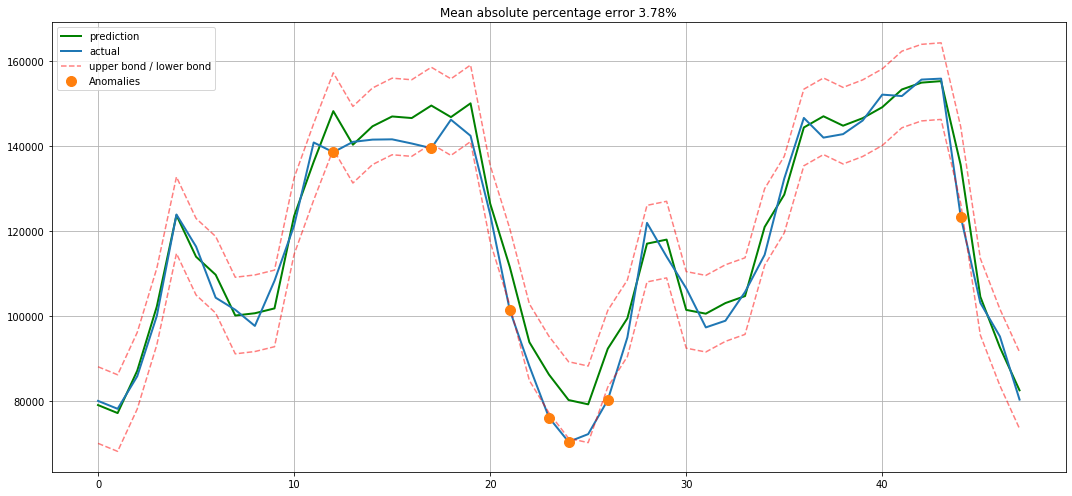

In [121]:
plotModelResults(gb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)